In [1]:
%matplotlib inline
timeSz = 32
from MakeModels import *
encoder = makeEncoder(timeSz)
decoder = makeDecoder()
autoencoder = makeAutoencoder(encoder,decoder)

autoencoder.load_weights('/home/ubuntu/SoftRobotRepresentation/ModelPrettyGoodBottleneck25.h5', by_name=True)

imageLSTM = makeImageLSTM(encoder)

Using TensorFlow backend.


(None, 25)
(1, None, 27)
(1, 64)
(1, 2)


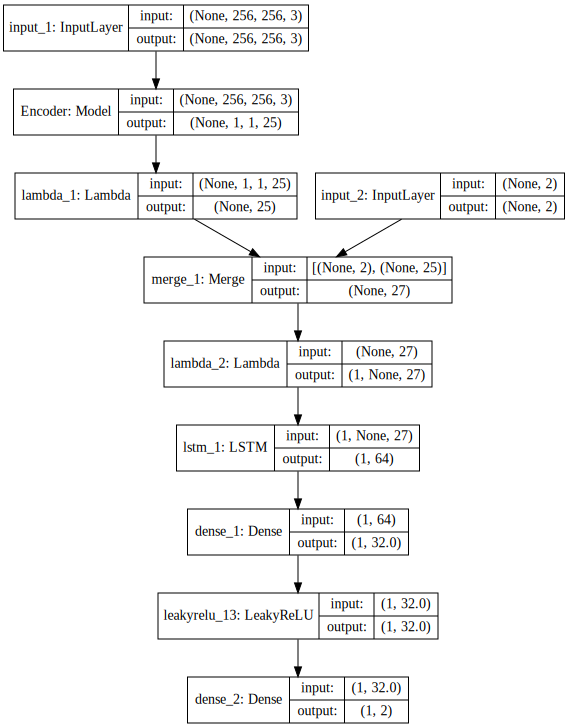

In [2]:
from IPython.display import SVG,display
from keras.utils.visualize_util import model_to_dot

display(SVG(model_to_dot(imageLSTM,show_shapes=True).create(prog='dot', format='svg')))

In [3]:
## Let's test some learning rates
import numpy as np
from numpy import random
import tqdm
from IPython.core.debugger import Pdb
from matplotlib import pyplot as plt

import pandas as pd


numEpochs = 50
numBatchesPerEpoch = 1000
nValBatches = 100

trainPath = "/home/ubuntu/SoftRobotRepresentation/Data/Training/0/"
valPath = "/home/ubuntu/SoftRobotRepresentation/Data/Validation/0/"

positionFiles = ['/home/ubuntu/SoftRobotRepresentation/Data/recordingRight.csv',
                 '/home/ubuntu/SoftRobotRepresentation/Data/recordingRight2.csv']

numFramesTrain = [21420,31430]
numFramesVal = [9180,13470]
numFrames = [e+f for e,f in zip(numFramesTrain,numFramesVal)]

predictAhead = 5

posTables = [pd.read_csv(e) for e in positionFiles]

positionDataTrain = np.empty(shape=(0,2))
positionDataVal = np.empty(shape=(0,2))
for i in range(len(positionFiles)):
    positionData = posTables[i].as_matrix(columns=['x(m)','y(m)'])
    positionDataTrain = np.concatenate((positionDataTrain,positionData[:numFramesTrain[i],:]))
    positionDataVal = np.concatenate((positionDataVal,positionData[numFramesTrain[i]:numFrames[i],:]))
    
print str(positionDataTrain.shape) +" " + str(positionDataVal.shape)

def trainGenerator():
    files = os.listdir(trainPath)
    files = ['%s%06d.jpg'%(trainPath,i) for i in range(len(files))]
    res = np.zeros(shape=(timeSz,imDim,imDim,3))
    while True:
        for i in range(numBatchesPerEpoch):
            resPos = positionDataTrain[i*timeSz:(i+1)*(timeSz),:]
            for j in range(timeSz):
                index = i*timeSz+j
                res[j,:] = plt.imread(files[index]).astype('float32')/255.0
                
            posRes = positionDataTrain[i*timeSz+predictAhead:(i+1)*timeSz+predictAhead,:]
            yield ([resPos,res],posRes)
        
def valGenerator():  
    files = os.listdir(valPath)
    files = ['%s%06d.jpg'%(valPath,i) for i in range(len(files))]
    res = np.zeros(shape=(timeSz,imDim,imDim,3))
    while True:
        for i in range(nValBatches):
            resPos = positionDataVal[i*timeSz:(i+1)*(timeSz),:]
            for j in range(timeSz):
                index = i*timeSz+j
                res[j,:] = plt.imread(files[index]).astype('float32')/255.0
                
            posRes = positionDataVal[i*timeSz+predictAhead:(i+1)*timeSz+predictAhead,:]
            yield ([resPos,res],posRes)
            
            

def trainGeneratorPlainPos():
    res = np.zeros(shape=(timeSz,2))
    while True:
        for i in range(numBatchesPerEpoch):
            res = positionDataTrain[i*timeSz:i*(timeSz+1),:]
            posRes = positionDataTrain[i*(timeSz+1)+predictAhead,:]
            yield (res,posRes)
        
def valGenerator():  
    res = np.zeros(shape=(timeSz,2))
    while True:
        for i in range(nValBatches):
            res = positionDataVal[i*timeSz:i*(timeSz+1),:]
            posRes = positionDataVal[i*(timeSz+1)+predictAhead,:]
            yield (res,posRes)

(52850, 2) (22650, 2)


In [4]:
## Let's test some learning rates
from keras.optimizers import Adam
import numpy as np
from numpy import random
from keras.callbacks import TensorBoard
from keras.callbacks import ModelCheckpoint
from keras.callbacks import ReduceLROnPlateau


lr = 5e-2
print "Learning rate=" + str(lr)
print "Compiling model"
imageLSTM.compile(optimizer=Adam(lr=lr),loss='mse')
print "Done compiling model"
history = imageLSTM.fit_generator(generator=trainGenerator(),
                                    samples_per_epoch=numBatchesPerEpoch*timeSz,
                                    nb_epoch=numEpochs,
                                    validation_data=valGenerator(),
                                    nb_val_samples=nValBatches*timeSz,
                                    callbacks=[TensorBoard(log_dir='/home/ubuntu/SoftRobotRepresentation/Data/Logs/0'),
                                               ModelCheckpoint('/home/ubuntu/SoftRobotRepresentation/LSTMModel.h5'),
                                               ReduceLROnPlateau(factor=0.2,patience=2)]
                                   )

Learning rate=0.05
Compiling model
Done compiling model
Epoch 1/50
 9312/32000 [=======>......................] - ETA: 189s - loss: 1.3030

KeyboardInterrupt: 

In [ ]:
from matplotlib import pyplot as plt

im = plt.imread('/home/ubuntu/SoftRobotRepresentation/Data/Training/0/021420.jpg')
plt.figure()
plt.imshow(im)

In [ ]:
'''Example script to generate text from Nietzsche's writings.

At least 20 epochs are required before the generated text
starts sounding coherent.

It is recommended to run this script on GPU, as recurrent
networks are quite computationally intensive.

If you try this script on new data, make sure your corpus
has at least ~100k characters. ~1M is better.
'''

from __future__ import print_function
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.layers import LSTM
from keras.optimizers import RMSprop
from keras.utils.data_utils import get_file
import numpy as np
import random
import sys

path = get_file('nietzsche.txt', origin="https://s3.amazonaws.com/text-datasets/nietzsche.txt")
text = open(path).read().lower()
print('corpus length:', len(text))

chars = sorted(list(set(text)))
print('total chars:', len(chars))
char_indices = dict((c, i) for i, c in enumerate(chars))
indices_char = dict((i, c) for i, c in enumerate(chars))

# cut the text in semi-redundant sequences of maxlen characters
maxlen = 40
step = 3
sentences = []
next_chars = []
for i in range(0, len(text) - maxlen, step):
    sentences.append(text[i: i + maxlen])
    next_chars.append(text[i + maxlen])
print('nb sequences:', len(sentences))

print('Vectorization...')
X = np.zeros((len(sentences), maxlen, len(chars)), dtype=np.bool)
y = np.zeros((len(sentences), len(chars)), dtype=np.bool)
for i, sentence in enumerate(sentences):
    for t, char in enumerate(sentence):
        X[i, t, char_indices[char]] = 1
    y[i, char_indices[next_chars[i]]] = 1


# build the model: a single LSTM
print('Build model...')
model = Sequential()
model.add(LSTM(128, input_shape=(maxlen, len(chars))))
model.add(Dense(len(chars)))
model.add(Activation('softmax'))

optimizer = RMSprop(lr=0.01)
model.compile(loss='categorical_crossentropy', optimizer=optimizer)


def sample(preds, temperature=1.0):
    # helper function to sample an index from a probability array
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds) / temperature
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    probas = np.random.multinomial(1, preds, 1)
    return np.argmax(probas)

# train the model, output generated text after each iteration
for iteration in range(1, 60):
    print()
    print('-' * 50)
    print('Iteration', iteration)
    Pdb().set_trace()
    model.fit(X, y, batch_size=128, nb_epoch=1)

    start_index = random.randint(0, len(text) - maxlen - 1)

    for diversity in [0.2, 0.5, 1.0, 1.2]:
        print()
        print('----- diversity:', diversity)

        generated = ''
        sentence = text[start_index: start_index + maxlen]
        generated += sentence
        print('----- Generating with seed: "' + sentence + '"')
        sys.stdout.write(generated)

        for i in range(400):
            x = np.zeros((1, maxlen, len(chars)))
            for t, char in enumerate(sentence):
                x[0, t, char_indices[char]] = 1.

            preds = model.predict(x, verbose=0)[0]
            next_index = sample(preds, diversity)
            next_char = indices_char[next_index]

            generated += next_char
            sentence = sentence[1:] + next_char

            sys.stdout.write(next_char)
            sys.stdout.flush()
        print()